## Final Project 2


* Student name: Reuben Hough
* Student pace: full time
* Scheduled project review date/time: 5/15/20
* Instructor name: Amber Yandow
* Blog post URL:


In [1]:
# importing libraries
import sqlite3
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FuncFormatter
from glob import glob
import os
import seaborn as sns
import warnings
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.metrics import mean_squared_error
from itertools import combinations
%matplotlib inline

In [2]:
# Opening and reading house data
df = pd.read_csv('kc_house_data.csv')
df.head(10)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503
5,7237550310,5/12/2014,1230000.0,4,4.50,5420,101930,1.0,0.0,0.0,...,11,3890,1530.0,2001,0.0,98053,47.6561,-122.005,4760,101930
6,1321400060,6/27/2014,257500.0,3,2.25,1715,6819,2.0,0.0,0.0,...,7,1715,?,1995,0.0,98003,47.3097,-122.327,2238,6819
7,2008000270,1/15/2015,291850.0,3,1.50,1060,9711,1.0,0.0,NaN,...,7,1060,0.0,1963,0.0,98198,47.4095,-122.315,1650,9711
8,2414600126,4/15/2015,229500.0,3,1.00,1780,7470,1.0,0.0,0.0,...,7,1050,730.0,1960,0.0,98146,47.5123,-122.337,1780,8113
9,3793500160,3/12/2015,323000.0,3,2.50,1890,6560,2.0,0.0,0.0,...,7,1890,0.0,2003,0.0,98038,47.3684,-122.031,2390,7570


In [3]:
# Null values in The waterfront, view, and yr_renovated columns
# can be replaced with zero
df.waterfront.replace(np.NaN, 0.0, inplace=True)
df.view.replace(np.NaN, 0.0, inplace=True)
df.yr_renovated.replace(np.NaN, 0.0, inplace=True)
# Checking if there are any null values
df.isnull().values.any()

False

In [4]:
# Creating a function to replace question marks with a float zero
def thisfunc(y):
    z = []
    for x in y:
        if '?' in x:
            z.append(float(x.replace('?', '0.0')))
        else:
            z.append(float(x))
    return z

In [5]:
# Running function for sqft_basement column
df.sqft_basement = thisfunc(df.sqft_basement)

In [6]:
# Checking for other symbols that might be in the data
df.isin(['?','/',"'",'.','.']).any()

id               False
date             False
price            False
bedrooms         False
bathrooms        False
sqft_living      False
sqft_lot         False
floors           False
waterfront       False
view             False
condition        False
grade            False
sqft_above       False
sqft_basement    False
yr_built         False
yr_renovated     False
zipcode          False
lat              False
long             False
sqft_living15    False
sqft_lot15       False
dtype: bool

In [7]:
# Making the Sale Date more useable
df['Year'] = df['date'].map(lambda x: '{}'.format(x[-4:].replace('/', '')))
df['Month'] = df['date'].map(lambda x: '{}'.format(x[:2].replace('/', '')))
df['Day'] = df['date'].map(lambda x: '{}'.format(x[-7:-5].replace('/', '')))
df['Day'] = df['Day'].map(lambda x: int(x))
df['Month'] = df['Month'].map(lambda x: int(x))
df['Year'] = df['Year'].map(lambda x: int(x))

In [8]:
# Turning the date into a Julian date to make it more useable
def julian(a,b,c):
    w=[]
    for x,y,z in zip(a,b,c):
         w.append(pd.Timestamp(year = x,  month = y, day = z).to_julian_date())
    return w

In [9]:
# Turning the date into a Julian date to make it more useable
df['Julian'] = julian(df['Year'], df['Month'], df['Day'])
df.sort_values(by='Julian')

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,Year,Month,Day,Julian
7316,2202500290,5/2/2014,435000.0,4,1.00,1450,8800,1.0,0.0,0.0,...,0.0,98006,47.5746,-122.135,1260,8942,2014,5,2,2456779.5
20586,7853361370,5/2/2014,555000.0,4,2.50,3310,6500,2.0,0.0,0.0,...,0.0,98065,47.5150,-121.870,2380,5000,2014,5,2,2456779.5
1040,7197300105,5/2/2014,550000.0,4,2.50,1940,10500,1.0,0.0,0.0,...,0.0,98052,47.6830,-122.114,2200,10500,2014,5,2,2456779.5
20543,3438501320,5/2/2014,295000.0,2,2.50,1630,1368,2.0,0.0,0.0,...,0.0,98106,47.5489,-122.363,1590,2306,2014,5,2,2456779.5
9587,472000620,5/2/2014,790000.0,3,2.50,2600,4750,1.0,0.0,0.0,...,0.0,98117,47.6833,-122.400,2380,4750,2014,5,2,2456779.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19381,8149600265,5/14/2015,725000.0,4,1.75,1980,5850,1.0,0.0,1.0,...,0.0,98116,47.5607,-122.391,1810,5850,2015,5,14,2457156.5
12623,4166600610,5/14/2015,335000.0,3,2.00,1410,44866,1.0,0.0,0.0,...,0.0,98023,47.3273,-122.370,2950,29152,2015,5,14,2457156.5
5632,7923600250,5/15/2015,450000.0,5,2.00,1870,7344,1.5,0.0,0.0,...,0.0,98007,47.5951,-122.144,1870,7650,2015,5,15,2457157.5
13040,5101400871,5/24/2015,445500.0,2,1.75,1390,6670,1.0,0.0,0.0,...,0.0,98115,47.6914,-122.308,920,6380,2015,5,24,2457166.5


In [10]:
print(df.describe())
print(df.info())

                 id         price      bedrooms     bathrooms   sqft_living  \
count  2.159700e+04  2.159700e+04  21597.000000  21597.000000  21597.000000   
mean   4.580474e+09  5.402966e+05      3.373200      2.115826   2080.321850   
std    2.876736e+09  3.673681e+05      0.926299      0.768984    918.106125   
min    1.000102e+06  7.800000e+04      1.000000      0.500000    370.000000   
25%    2.123049e+09  3.220000e+05      3.000000      1.750000   1430.000000   
50%    3.904930e+09  4.500000e+05      3.000000      2.250000   1910.000000   
75%    7.308900e+09  6.450000e+05      4.000000      2.500000   2550.000000   
max    9.900000e+09  7.700000e+06     33.000000      8.000000  13540.000000   

           sqft_lot        floors    waterfront          view     condition  \
count  2.159700e+04  21597.000000  21597.000000  21597.000000  21597.000000   
mean   1.509941e+04      1.494096      0.006760      0.233181      3.409825   
std    4.141264e+04      0.539683      0.081944    

In [11]:
# 33 bedrooms is almost certainly an error, probably meant to be 3, but it will be dropped
df = df.drop([15856])

In [12]:
# Defining categorical variables, there seems to be only one
categorical = ['zipcode']

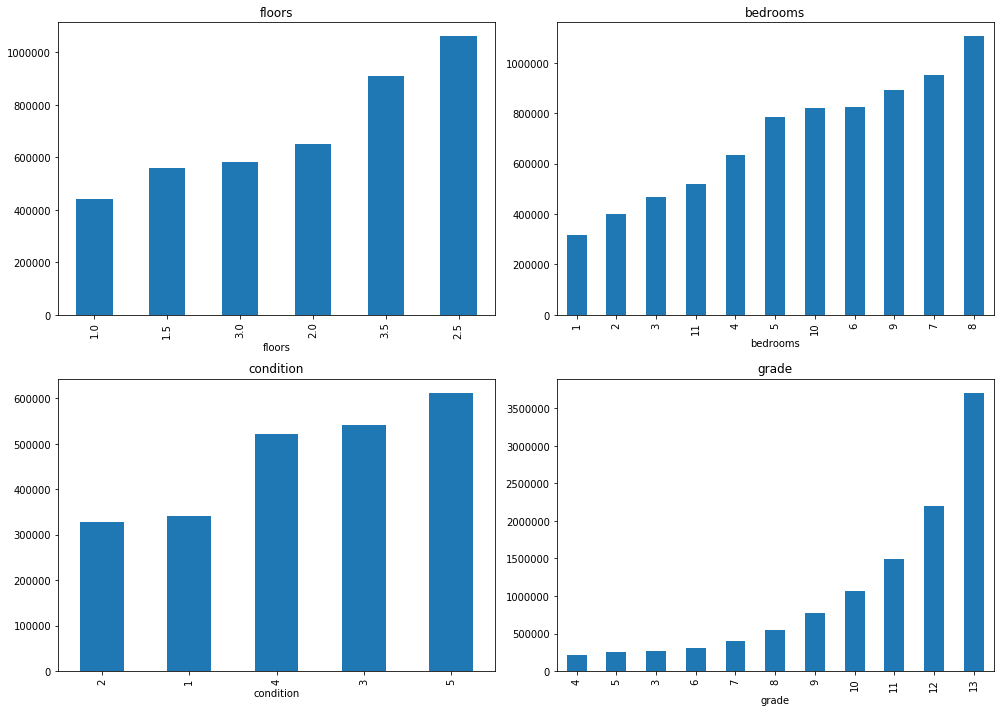

In [13]:
# Plotting price in relation to several different factors
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14,10))
variables = ['floors', 'bedrooms', 'condition', 'grade']

for column, ax in zip(variables, axes.flatten()):
    (df.groupby(column).mean()['price'].sort_values().plot.bar(ax=ax))                
    
    ax.set_title(column)
    
fig.tight_layout()

In [14]:
outcome = 'price'
cols = ['grade', 'sqft_lot', 'bathrooms', 'sqft_living']
predictors = '+'.join(cols)
formula = outcome + '~' + predictors
model = ols(formula=formula, data=df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.538
Model:                            OLS   Adj. R-squared:                  0.538
Method:                 Least Squares   F-statistic:                     6292.
Date:                Wed, 13 May 2020   Prob (F-statistic):               0.00
Time:                        19:33:39   Log-Likelihood:            -2.9903e+05
No. Observations:               21596   AIC:                         5.981e+05
Df Residuals:                   21591   BIC:                         5.981e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -6.005e+05   1.33e+04    -45.166      0.000   -6.27e+05   -5.74e+05
grade        1.044e+05   2291.143     45.576      0.000    9.99e+04    1.09e+05
sqft_lot       -0.2704      0.042     -6.476      0.000      -0.352      -0.189
bathrooms   -3.974e+04   3458.023    -11.492      0.000   -4.65e+04    -3.3e+04
sqft_living   206.3599      3.372     61.205      0.000     199.751     212.968
==============================================================================
Omnibus:                    16851.616   Durbin-Watson:                   1.980
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           992101.070
Skew:                           3.272   Prob(JB):                         0.00
Kurtosis:                      35.553   Cond. No.                     3.49e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.49e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

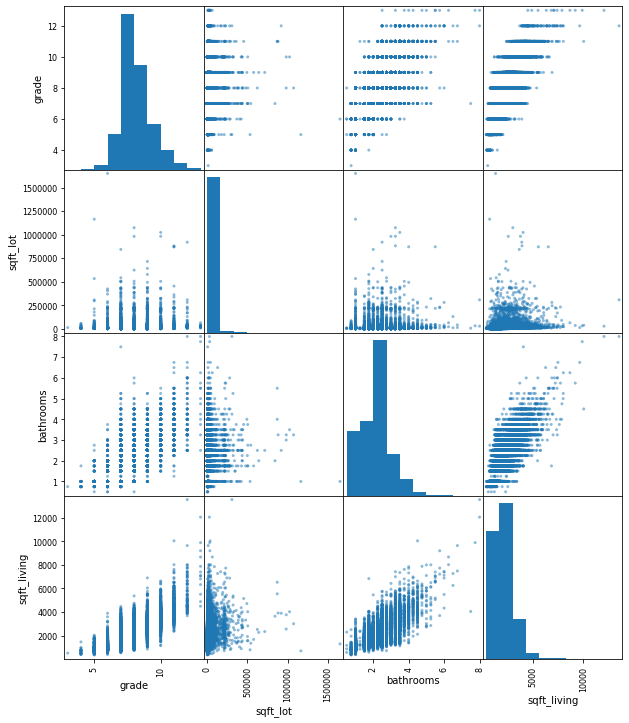

In [15]:
pd.plotting.scatter_matrix(df[cols], figsize=(10,12));

In [16]:
# Checking if there is too much correlation between any columns
abs(df.corr()) > 0.75

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,Year,Month,Day,Julian
id,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
price,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
bedrooms,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
bathrooms,False,False,False,True,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
sqft_living,False,False,False,True,True,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
sqft_lot,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
floors,False,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
waterfront,False,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
view,False,False,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
condition,False,False,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False


The correlations are few and generally expected, with the square footage of a house correlated with the square footage of surrounding houses, and larger houses are correlated with a higher overall grade.

In [27]:
# Making a function that normalizes a set of data
def normalize(x):
    return (x - x.mean()) / x.std()
# Making a regression line function that will be used from now on
def slope(x, y):
# Function that calculates slope
    m = (((np.mean(x)*np.mean(y)) - np.mean(x*y)) / ((np.mean(x)**2) - np.mean(x**2)))
    return m
# Defining a function that calculates and returns the slope and intercept, m and c in the formula y = mx + b
def best_fit(x, y):
    m = slope(x, y)
    b = np.mean(y) - m*np.mean(x)
# This function takes the slope and intercept, and calculates mx + b for each x
def reg_line (m, b, X):
    return [(m*x)+b for x in X]
# This function calculates the sum of squared errors between regression and mean line 
def sum_sq_err(x, y):
    z =  sum((y - x) * (y - x))
    return z
# This function calculates the r^2, which is how much the dependent variable (price) is affected by the independent variable
def r_squared(yreal, ypredicted):
    mean = [np.mean(yreal) for y in yreal]
    # Squared error
    SSreg = sum_sq_err(yreal, ypredicted)
    SSTotal = sum_sq_err(yreal, mean)
    # Calculates r-squared 
    rsq =  1 - (sq_err_reg/sq_err_y_mean)
    return rsq
# Plots data and a regression line
def plot_regression(X, Y, Y_pred):
    plt.scatter(X, Y, color='#BAEBAE', label='data')
    plt.plot(X, Y_pred, label='regression line')
    plt.show()
# Diagnostic information for the current plot
def plot_info():
    print ('Regression Diagnostics')
    print ('----------------------------')
    print ('Slope:', m)
    print ('Y-Intercept:', b)
    print ('R-Squared:', r_squared)
    print ('----------------------------')
    print ('Model: Y =',round(m, 2),'* X +', round(b, 2))
X = df.Julian
Y = df.price
plot_info()
plot_regression(X, Y, Y_pred)

Regression Diagnostics
----------------------------


NameError: name 'm' is not defined

In [18]:
# Making a function that normalizes a set of data
def normalize(x):
    return (x - x.mean()) / x.std()

In [19]:
# Making a regression line function that will be used from now on
def slope(x, y):
# Function that calculates slope
    m = (((np.mean(x)*np.mean(y)) - np.mean(x*y)) / ((np.mean(x)**2) - np.mean(x**2)))
    return m

In [20]:
# Defining a function that calculates and returns the slope and intercept, m and c in the formula y = mx + b
def best_fit(x, y):
    m = slope(x, y)
    b = np.mean(y) - m*np.mean(x)

In [21]:
# This function takes the slope and intercept, and calculates mx + b for each x
def reg_line (m, b, X):
    return [(m*x)+b for x in X]

In [22]:
# This function calculates the sum of squared errors between regression and mean line 
def sum_sq_err(x, y):
    z =  sum((y - x) * (y - x))
    return z

In [23]:
# This function calculates the r^2, which is how much the dependent variable (price) is affected by the independent variable
def r_squared(yreal, ypredicted):
    mean = [np.mean(yreal) for y in yreal]
    # Squared error
    SSreg = sum_sq_err(yreal, ypredicted)
    SSTotal = sum_sq_err(yreal, mean)
    # Calculates r-squared 
    rsq =  1 - (sq_err_reg/sq_err_y_mean)
    return rsq

In [24]:
# Plots data and a regression line
def plot_regression(X, Y, Y_pred):
    plt.scatter(X, Y, color='#BAEBAE', label='data')
    plt.plot(X, Y_pred, label='regression line')
    plt.show()

In [25]:
# Diagnostic information for the current plot
def plot_info():
    print ('Regression Diagnostics')
    print ('----------------------------')
    print ('Slope:', m)
    print ('Y-Intercept:', b)
    print ('R-Squared:', r_squared)
    print ('----------------------------')
    print ('Model: Y =',round(m, 2),'* X +', round(b, 2))

In [26]:
X = df.Julian
Y = df.price
plot_info()
plot_regression(X, Y, Y_pred)

Regression Diagnostics
----------------------------


NameError: name 'm' is not defined